# Pruebas de rendimiento sobre Streaming Inference

Es necesario tener instalada la versión de java 1.8:

In [2]:
%%bash
java -version

java version "1.8.0_171"
Java(TM) SE Runtime Environment (build 1.8.0_171-b11)
Java HotSpot(TM) 64-Bit Server VM (build 25.171-b11, mixed mode)


También es necesario tener añadida al PATH la carpeta bin de spark 2.2.1 para hadoop 2.7 o posterior ([descarga](https://spark.apache.org/downloads.html)).

In [2]:
import pandas as pd
import seaborn as sns
from matplotlib import pylab
import numpy as np
pylab.rcParams['figure.figsize'] = (16.0, 8.0)
sns.set(style="whitegrid")

## Creación de las colecciones de test

Esta función crea en la carpeta input una lista de archivos json con colecciones de elementos:

In [4]:
def createTestFileCollection(elements=120, entities=2, versions=2, depth=2, fields=2, batch=12):
    !rm -rf input
    !mkdir -p input
    out = !java -jar es.um.nosql.streaminginference.benchmark-0.0.1-SNAPSHOT-jar-with-dependencies.jar \
    --elements $elements \
    --entities $entities \
    --versions $versions \
    --depth $depth \
    --fields $fields \
    --mode file \
    --flow stream \
    --batch $batch \
    --output input/collection.json \
    --delay 10

Esta función rellena la base de datos *benchmark* con entidades de prueba:

In [5]:
def createTestMongoCollection(elements=120, entities=2, versions=2, depth=2, fields=2):
    out = !java -jar es.um.nosql.streaminginference.benchmark-0.0.1-SNAPSHOT-jar-with-dependencies.jar \
    --elements $elements \
    --entities $entities \
    --versions $versions \
    --depth $depth \
    --fields $fields \
    --mode mongo \
    --host localhost \
    --port 27017 \
    --database benchmark    

Esta función crea un único archivo json con una colección de elementos en la carpeta input con nombre "collection":

In [6]:
def createTestSingleCollection(elements=120, entities=2, versions=2, depth=2, fields=2):
    !rm -rf input
    !mkdir -p input
    out = !java -jar es.um.nosql.streaminginference.benchmark-0.0.1-SNAPSHOT-jar-with-dependencies.jar \
    --elements $elements \
    --entities $entities \
    --versions $versions \
    --depth $depth \
    --fields $fields \
    --mode file \
    --output input/collection.json

Esta función determina el comando a utilizar en función del modo de funcionamiento:

In [7]:
def createTestCollection(mode="file", elements=120, entities=2, versions=2, depth=2, fields=2, batch=12):
    !mkdir -p output
    if (mode == "file"):
        createTestFileCollection(elements, entities, versions, depth, fields, batch)
    elif (mode == "mongo"):
        createTestMongoCollection(elements, entities, versions, depth, fields)
    elif (mode == "single"):
        createTestSingleCollection(elements, entities, versions, depth, fields) 

## Benchmarking de aplicaciones

Esta función ejecuta la aplicación de inferencia sobre una serie de colecciones previamente creada y vuelca en *stats.csv* los resultados:

In [8]:
def benchmarkFile(interval=1000, kryo="true"):
    out = !spark-submit --driver-memory 8g --master local[*] es.um.nosql.streaminginference.json2dbschema-0.0.1-SNAPSHOT-jar-with-dependencies.jar \
    --mode file \
    --input input \
    --benchmark true \
    --interval $interval \
    --kryo $kryo

Esta función ejecuta la aplicación de inferencia sobre la base de datos previamente creada y genera el archivo *stats.csv*:

In [9]:
def benchmarkMongo(interval=1000, block=200, kryo="true"):
    out = !spark-submit --driver-memory 8g --master local[*] es.um.nosql.streaminginference.json2dbschema-0.0.1-SNAPSHOT-jar-with-dependencies.jar \
    --mode mongo \
    --database benchmark \
    --host localhost \
    --port 27017 \
    --benchmark true \
    --interval $interval \
    --block-interval $block \
    --kryo $kryo

Esta función ejecuta la aplicación de inferencia sobre la colección creada genera el archivo *stats.csv*, en este caso solamente se mostrará el tiempo de procesamiento:

In [10]:
def benchmarkSingle():
    out = !spark-submit --driver-memory 8g --master local[*] es.um.nosql.streaminginference.json2dbschema-0.0.1-SNAPSHOT-jar-with-dependencies.jar \
    --mode single \
    --input input/collection.json \
    --benchmark true

Esta función determina el comando a utilizar en función del modo de funcionamiento:

In [11]:
def benchmarkSparkApp(mode="file", interval=1000, block=200, kryo="true"):
    if (mode == "file"):
        benchmarkFile(interval, kryo)
    elif (mode == "mongo"):
        benchmarkMongo(interval, block, kryo)
    elif (mode== "single"):
        benchmarkSingle()

## Todo junto

La siguiente función compone las funciones anteriores para ejecutar una prueba con los parámetros introducidos:

In [12]:
def benchmark(mode="file", interval=1000, block=200, elements=120, entities=2, versions=2, depth=2, fields=2, batch=12, kryo="true"):
    global benchmarked
    !rm -f output/stats.csv
    createTestCollection(mode, elements, entities, versions, depth, fields, batch)
    for x in range(0, 10):
        benchmarkSparkApp(mode, interval, block, kryo)
    benchmarked = pd.read_csv("output/stats.csv")
    return benchmarked

## Pruebas

Creación de una colección de 60000 elementos segmentada en 5 archivos:

In [135]:
createTestCollection(mode="file", elements=60000, batch=12000)

Creación de un único archivo con 60000 elementos:

In [131]:
createTestCollection(mode="single", elements=60000)

Inserción en la base de datos "benchmark" de MongoDB de 60000 elementos:

In [132]:
createTestCollection(mode="mongo", elements=60000)

Prueba de ejecución de 60000 elementos en modo file, en batches de 12000 elementos:

In [134]:
benchmark(mode="file",elements=60000, batch=12000)

,BATCH_INTERVAL,BLOCK_INTERVAL,PROCESSING_INTERVAL,TOTAL_BATCHES,TOTAL_DELAY,TOTAL_PROCESSING,TOTAL_IDLE,TOTAL_RECORDS,AVERAGE_DELAY,AVERAGE_PROCESSING,AVERAGE_IDLE,AVERAGE_RECORDS,MAX_PROCESSING,MAX_IDLE,MAX_DELAY
0,1000,200,126,1,1732,1725,0,0,1732,1725,0,0,1725,0,1732
1,1000,200,105,1,1688,1680,0,0,1688,1680,0,0,1680,0,1688
2,1000,200,150,1,1836,1829,0,0,1836,1829,0,0,1829,0,1836
3,1000,200,143,1,1746,1740,0,0,1746,1740,0,0,1740,0,1746
4,1000,200,141,1,1784,1777,0,0,1784,1777,0,0,1777,0,1784
5,1000,200,147,1,1793,1784,0,0,1793,1784,0,0,1784,0,1793
6,1000,200,147,1,1812,1806,0,0,1812,1806,0,0,1806,0,1812
7,1000,200,145,1,1719,1714,0,0,1719,1714,0,0,1714,0,1719
8,1000,200,157,1,1539,1533,0,0,1539,1533,0,0,1533,0,1539
9,1000,200,133,1,1577,1572,0,0,1577,1572,0,0,1572,0,1577


Prueba de ejecución de 30000 elementos en modo single:

In [136]:
benchmark(mode="single",elements=60000)

,TOTAL_PROCESSING
0,1142
1,1097
2,1060
3,1047
4,1106
5,1157
6,1151
7,1190
8,1140
9,1165


Prueba de ejecución de 1200 elementos en modo mongo:

In [69]:
benchmark(mode="mongo", elements=60000)

,BATCH_INTERVAL,BLOCK_INTERVAL,PROCESSING_INTERVAL,TOTAL_BATCHES,TOTAL_DELAY,TOTAL_PROCESSING,TOTAL_IDLE,TOTAL_RECORDS,AVERAGE_DELAY,AVERAGE_PROCESSING,AVERAGE_IDLE,AVERAGE_RECORDS,MAX_PROCESSING,MAX_IDLE,MAX_DELAY
0,1000,200,1992,2,653,646,1354,1200,326,323,677,600,889,0,536
1,1000,200,988,1,495,494,506,1200,495,494,506,1200,506,0,495
2,1000,200,1991,2,592,586,1414,1200,296,293,707,600,887,0,474
3,1000,200,997,1,546,545,455,1200,546,545,455,1200,455,0,546
4,1000,200,994,1,494,493,507,1200,494,493,507,1200,507,0,494
5,1000,200,989,1,502,495,505,1200,502,495,505,1200,505,0,502
6,1000,200,996,1,505,504,496,1200,505,504,496,1200,496,0,505
7,1000,200,993,1,511,506,494,1200,511,506,494,1200,494,0,511
8,1000,200,994,1,498,497,503,1200,498,497,503,1200,503,0,498
9,1000,200,996,1,510,506,494,1200,510,506,494,1200,494,0,510


## Medición de parámetros

Estudio del efecto de la serialización Kryo en la aplicación:

Text(0,0.5,u'Milisegundos de procesamiento')

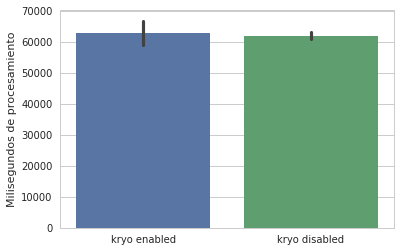

In [58]:
results = pd.DataFrame()
df = benchmark(mode="file", elements=2400000, batch=80000, entities=30, versions=30, depth=5, fields=4, kryo="true")
df.to_csv("kryo-enabled.csv")
results["kryo enabled"] = df["TOTAL_PROCESSING"]
df = benchmark(mode="file", elements=2400000, batch=80000,  entities=30, versions=30, depth=5, fields=4, kryo="false")
df.to_csv("kryo-disabled.csv")
results["kryo disabled"] = df["TOTAL_PROCESSING"]
ax = sns.barplot(data=results)
ax.set_ylabel("Milisegundos de procesamiento")

Estudio del efecto del número de entidades en el tiempo de procesamiento:

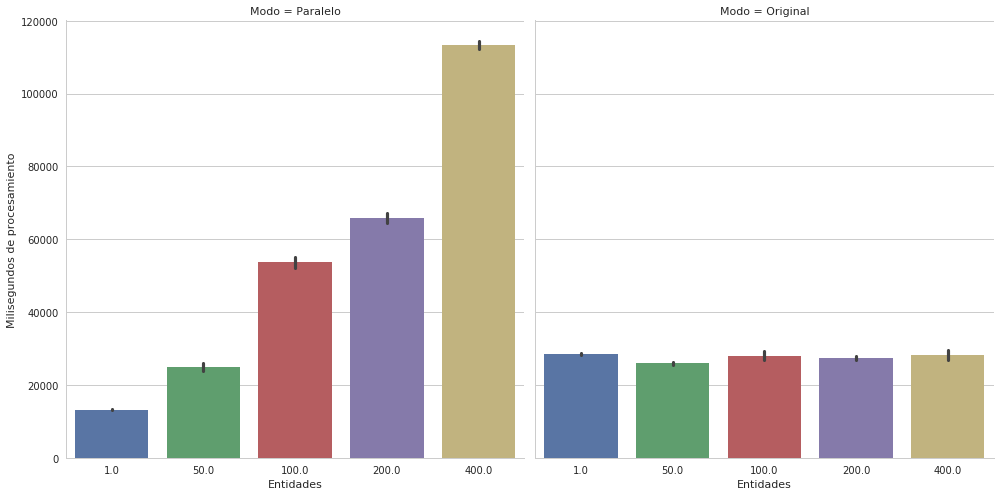

In [52]:
ents = np.array([])
mode = np.array([])
millis = np.array([])
for entities in [1, 50, 100, 200, 400]:
    df = benchmark(mode="file", elements=2400000, batch=80000, entities=entities, versions=1, depth=2, fields=2, kryo="true")
    df.to_csv("file-entities-"+str(entities)+".csv")
    length = df["TOTAL_PROCESSING"].size
    ents = np.append(ents, np.repeat(entities, length))
    mode = np.append(mode, np.repeat("Paralelo", length))
    millis = np.append(millis, df["TOTAL_PROCESSING"].as_matrix())
    df = benchmark(mode="single", elements=2400000, entities=entities, versions=1, depth=2, fields=2)
    df.to_csv("original-file-entities-"+str(entities)+".csv")
    length = df["TOTAL_PROCESSING"].size
    ents = np.append(ents, np.repeat(entities, length))
    mode = np.append(mode, np.repeat("Original", length))
    millis = np.append(millis, df["TOTAL_PROCESSING"].as_matrix())
    
results = pd.DataFrame({"Entidades":ents, "Modo": mode, "Milisegundos de procesamiento": millis})
sns.factorplot(x="Entidades", y="Milisegundos de procesamiento", col="Modo", data=results, kind="bar", size=7)

Estudio del efecto del número de versiones en el tiempo de procesamiento:

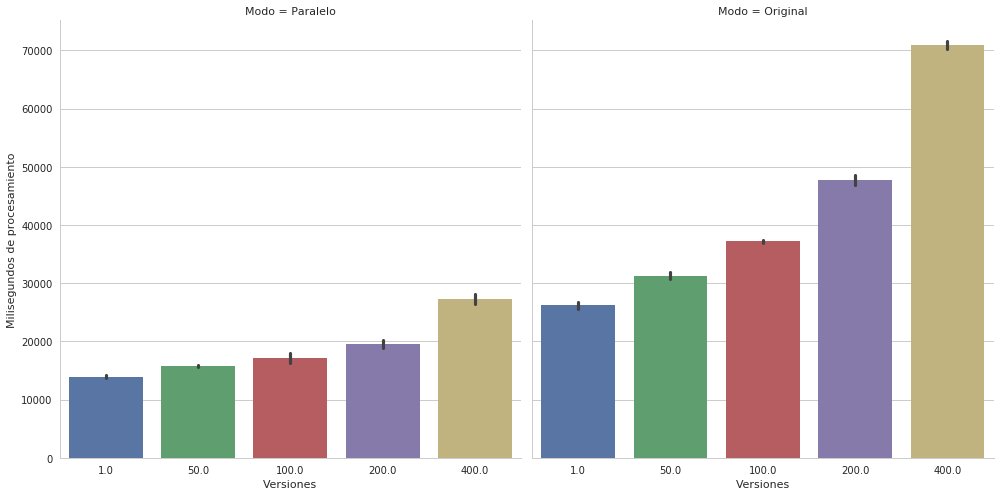

In [53]:
vers = np.array([])
mode = np.array([])
millis = np.array([])

for versions in [1, 50, 100, 200, 400]:
    df = benchmark(mode="file", elements=2400000, batch=80000, entities=1, versions=versions, depth=2, fields=2, kryo="true")
    df.to_csv("file-versions-"+str(versions)+".csv")
    length = df["TOTAL_PROCESSING"].size
    vers = np.append(vers, np.repeat(versions, length))
    mode = np.append(mode, np.repeat("Paralelo", length))
    millis = np.append(millis, df["TOTAL_PROCESSING"].as_matrix())
    df = benchmark(mode="single", elements=2400000, entities=1, versions=versions, depth=2, fields=2)
    df.to_csv("original-file-versions-"+str(versions)+".csv")
    vers = np.append(vers, np.repeat(versions, length))
    mode = np.append(mode, np.repeat("Original", length))
    millis = np.append(millis, df["TOTAL_PROCESSING"].as_matrix())    
    
results = pd.DataFrame({"Versiones":vers, "Modo": mode, "Milisegundos de procesamiento": millis})
sns.factorplot(x="Versiones", y="Milisegundos de procesamiento", col="Modo", data=results, kind="bar", size=7)

Estudio del efecto del número de elementos en el tiempo de procesamiento:

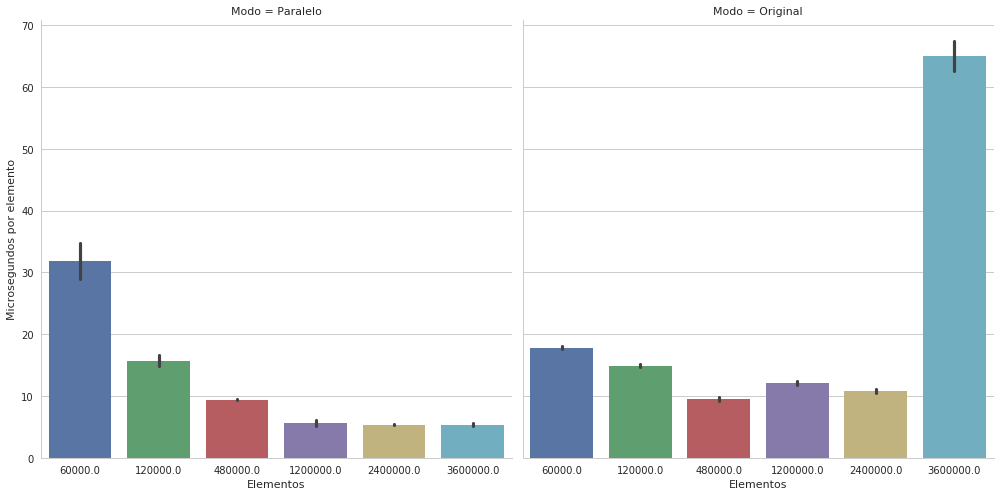

In [62]:
elems = np.array([])
mode = np.array([])
micros = np.array([])

for elements in [60000, 120000, 480000, 1200000, 2400000, 3600000]:
    df = benchmark(mode="file", elements=elements, batch=(elements/30), entities=1, versions=1, depth=2, fields=2, kryo="true")
    df.to_csv("light-file-elements-"+str(elements)+".csv")
    length = df["TOTAL_PROCESSING"].size
    elems = np.append(elems, np.repeat(elements, length))
    mode = np.append(mode, np.repeat("Paralelo", length))
    micros = np.append(micros, (df["TOTAL_PROCESSING"]*1000/elements).as_matrix())
    df = benchmark(mode="single", elements=elements, entities=1, versions=1, depth=2, fields=2)
    df.to_csv("light-original-file-elements-"+str(elements)+".csv")
    elems = np.append(elems, np.repeat(elements, length))
    mode = np.append(mode, np.repeat("Original", length))
    micros = np.append(micros, (df["TOTAL_PROCESSING"]*1000/elements).as_matrix())
    
results = pd.DataFrame({"Elementos":elems, "Modo": mode, "Microsegundos por elemento": micros})
sns.factorplot(x="Elementos", y="Microsegundos por elemento", col="Modo", data=results, kind="bar", size=7)

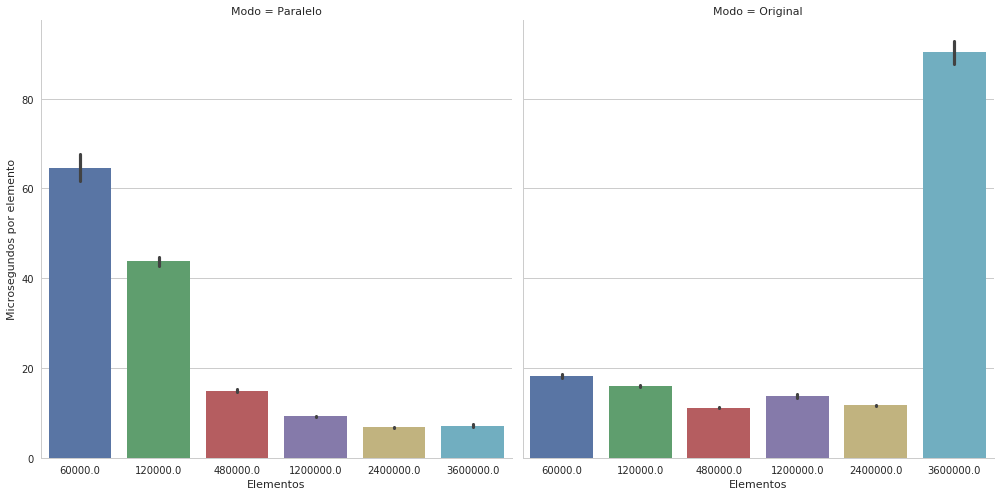

In [63]:
elems = np.array([])
mode = np.array([])
micros = np.array([])

for elements in [60000, 120000, 480000, 1200000, 2400000, 3600000]:
    df = benchmark(mode="file", elements=elements, batch=(elements/30), entities=20, versions=20, depth=2, fields=2, kryo="true")
    df.to_csv("medium-file-elements-"+str(elements)+".csv")
    length = df["TOTAL_PROCESSING"].size
    elems = np.append(elems, np.repeat(elements, length))
    mode = np.append(mode, np.repeat("Paralelo", length))
    micros = np.append(micros, (df["TOTAL_PROCESSING"]*1000/elements).as_matrix())
    df = benchmark(mode="single", elements=elements, entities=20, versions=20, depth=2, fields=2)
    df.to_csv("medium-original-file-elements-"+str(elements)+".csv")
    elems = np.append(elems, np.repeat(elements, length))
    mode = np.append(mode, np.repeat("Original", length))
    micros = np.append(micros, (df["TOTAL_PROCESSING"]*1000/elements).as_matrix())
    
results = pd.DataFrame({"Elementos":elems, "Modo": mode, "Microsegundos por elemento": micros})
sns.factorplot(x="Elementos", y="Microsegundos por elemento", col="Modo", data=results, kind="bar", size=7)

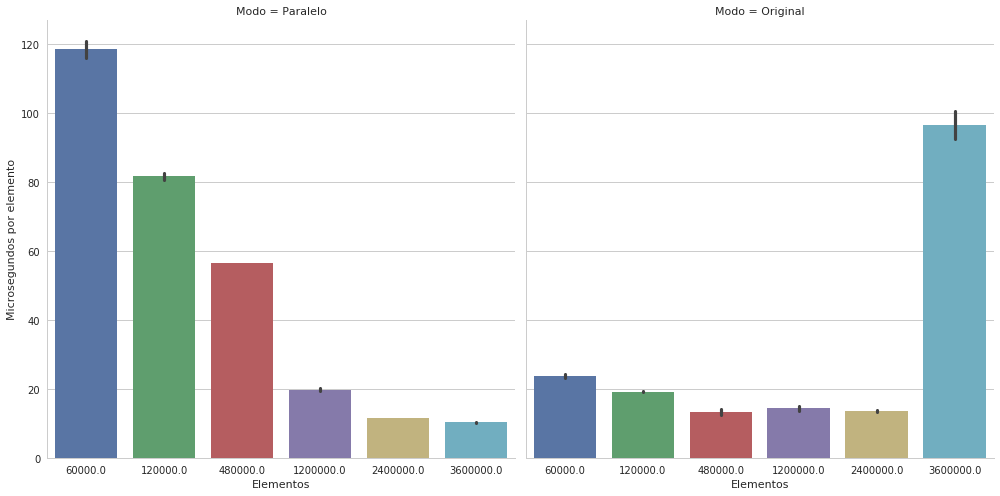

In [64]:
elems = np.array([])
mode = np.array([])
micros = np.array([])

for elements in [60000, 120000, 480000, 1200000, 2400000, 3600000]:
    df = benchmark(mode="file", elements=elements, batch=(elements/30), entities=50, versions=50, depth=2, fields=2, kryo="true")
    df.to_csv("hard-file-elements-"+str(elements)+".csv")
    length = df["TOTAL_PROCESSING"].size
    elems = np.append(elems, np.repeat(elements, length))
    mode = np.append(mode, np.repeat("Paralelo", length))
    micros = np.append(micros, (df["TOTAL_PROCESSING"]*1000/elements).as_matrix())
    df = benchmark(mode="single", elements=elements, entities=50, versions=50, depth=2, fields=2)
    df.to_csv("hard-original-file-elements-"+str(elements)+".csv")
    elems = np.append(elems, np.repeat(elements, length))
    mode = np.append(mode, np.repeat("Original", length))
    micros = np.append(micros, (df["TOTAL_PROCESSING"]*1000/elements).as_matrix())
    
results = pd.DataFrame({"Elementos":elems, "Modo": mode, "Microsegundos por elemento": micros})
sns.factorplot(x="Elementos", y="Microsegundos por elemento", col="Modo", data=results, kind="bar", size=7)

Estudio del efecto del número de particiones en el tiempo de procesamiento:

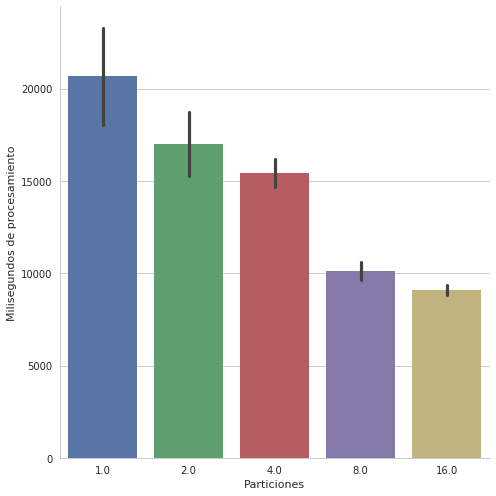

In [57]:
parts = np.array([])
millis = np.array([])

for partitions in [1, 2, 4, 8, 16]:
    df = benchmark(mode="file", elements=2400000, batch=(elements/partitions), entities=1, versions=1, depth=2, fields=2, kryo="true")
    df.to_csv("file-partitions-"+str(partitions)+".csv")
    length = df["TOTAL_PROCESSING"].size
    parts = np.append(parts, np.repeat(partitions, length))
    millis = np.append(millis, df["TOTAL_PROCESSING"].as_matrix())
        
results = pd.DataFrame({"Particiones":parts, "Milisegundos de procesamiento": millis})
sns.factorplot(x="Particiones", y="Milisegundos de procesamiento", data=results, kind="bar", size=7)

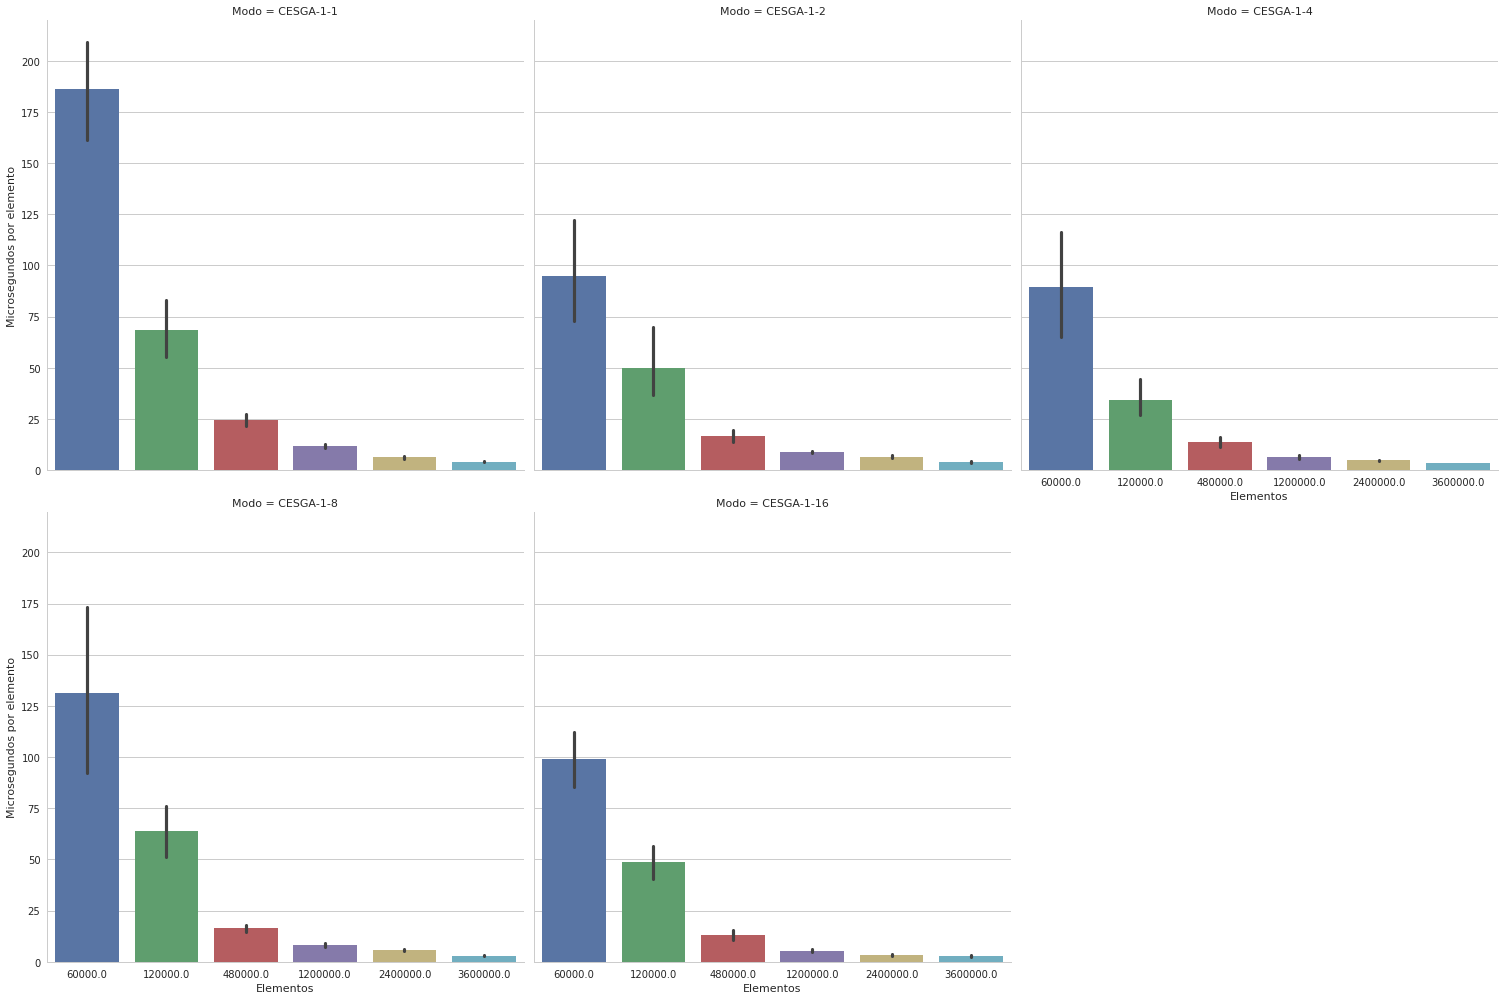

In [73]:
elems = np.array([])
mode = np.array([])
micros = np.array([])

for elements in [60000, 120000, 480000, 1200000, 2400000, 3600000]:
    for executors in [1, 2, 4, 8, 16]:
        df = pd.read_csv("cesga/results-"+str(elements)+"-1-1-"+str(elements/30)+"-"+str(executors)+".csv")
        length = df["TOTAL_PROCESSING"].size
        elems = np.append(elems, np.repeat(elements, length))
        mode = np.append(mode, np.repeat("CESGA-1-"+str(executors), length))
        micros = np.append(micros, (df["TOTAL_PROCESSING"]*1000/elements).as_matrix())

results = pd.DataFrame({"Elementos":elems, "Modo": mode, "Microsegundos por elemento": micros})
sns.factorplot(x="Elementos", y="Microsegundos por elemento", col="Modo", col_wrap=3, data=results, kind="bar", size=7)

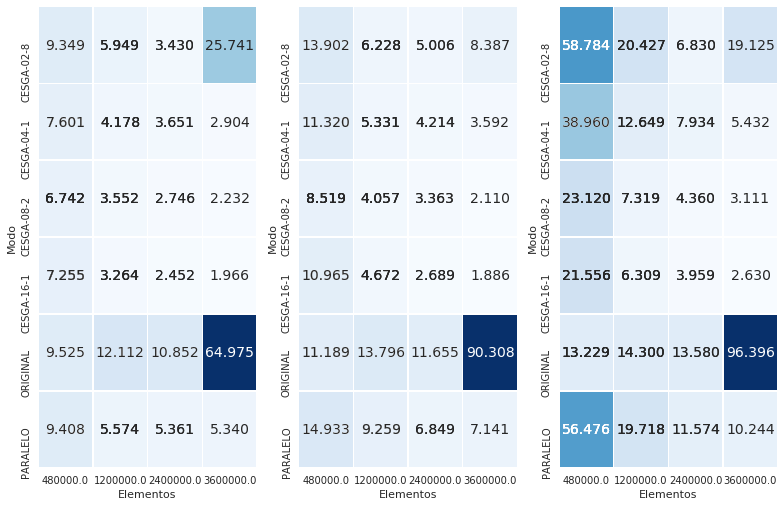

In [97]:


import matplotlib.pyplot as plt
import os.path
f, ax = plt.subplots(1,3, figsize=(11, 7))

f.tight_layout()
cmap = sns.color_palette("Blues", n_colors=1000)
row = 0

for version in [1, 20, 50]:
    
    elems = np.array([])
    mode = np.array([])
    micros = np.array([])
    for elements in [480000, 1200000, 2400000, 3600000]:
        
        df = pd.read_csv("local/file-elements-"+str(version)+"-"+str(elements)+".csv")
        length = df["TOTAL_PROCESSING"].size
        elems = np.append(elems, np.repeat(elements, length))
        mode = np.append(mode, np.repeat("PARALELO", length))
        micros = np.append(micros, (df["TOTAL_PROCESSING"]*1000/elements).as_matrix())

        df = pd.read_csv("local/original-file-elements-"+str(version)+"-"+str(elements)+".csv")
        length = df["TOTAL_PROCESSING"].size
        elems = np.append(elems, np.repeat(elements, length))
        mode = np.append(mode, np.repeat("ORIGINAL", length))
        micros = np.append(micros, (df["TOTAL_PROCESSING"]*1000/elements).as_matrix())

        for executors in [4, 16]:
            df = pd.read_csv("cesga/results-"+str(elements)+"-"+str(version)+"-"+str(version)+"-"+str(elements/30)+"-"+str(executors)+"-1.csv")
            length = df["TOTAL_PROCESSING"].size
            elems = np.append(elems, np.repeat(elements, length))
            mode = np.append(mode, np.repeat("CESGA-"+str(executors).zfill(2)+"-1", length))
            micros = np.append(micros, (df["TOTAL_PROCESSING"]*1000/elements).as_matrix())
            
        df = pd.read_csv("cesga/results-"+str(elements)+"-"+str(version)+"-"+str(version)+"-"+str(elements/30)+"-2-8.csv")
        length = df["TOTAL_PROCESSING"].size
        elems = np.append(elems, np.repeat(elements, length))
        mode = np.append(mode, np.repeat("CESGA-02-8", length))
        micros = np.append(micros, (df["TOTAL_PROCESSING"]*1000/elements).as_matrix())
        
        df = pd.read_csv("cesga/results-"+str(elements)+"-"+str(version)+"-"+str(version)+"-"+str(elements/30)+"-8-2.csv")
        length = df["TOTAL_PROCESSING"].size
        elems = np.append(elems, np.repeat(elements, length))
        mode = np.append(mode, np.repeat("CESGA-08-2", length))
        micros = np.append(micros, (df["TOTAL_PROCESSING"]*1000/elements).as_matrix())
        
        results = pd.DataFrame({"Elementos":elems, "Modo": mode, "Microsegundos por elemento": micros})
        grouped = results.groupby(['Elementos', 'Modo'], as_index=False).mean()
        grouped.sort_values("Modo")
        pivoted = grouped.pivot("Modo", "Elementos", "Microsegundos por elemento")
        #display(pivoted)
        sns.heatmap(pivoted, annot=True, linewidths=.5, fmt="1.3f", ax=ax[row], cmap=cmap, cbar=False, annot_kws={"size": 14})  
    #ax[row].yticks(np.arange(0, 1, step=0.2))
    row += 1

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
plt.show()

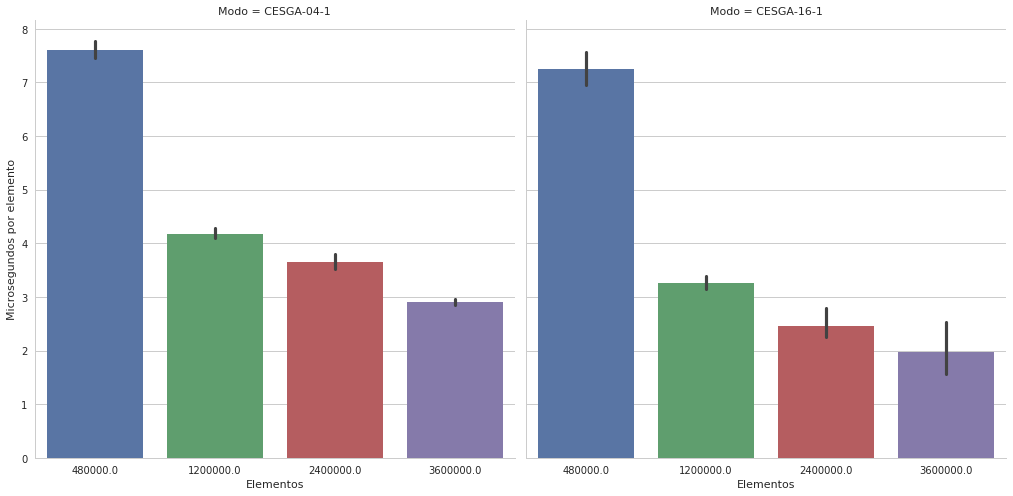

In [4]:
elems = np.array([])
mode = np.array([])
micros = np.array([])
for elements in [480000, 1200000, 2400000, 3600000]:

    for executors in [4, 16]:
        df = pd.read_csv("cesga/results-"+str(elements)+"-1-1-"+str(elements/30)+"-"+str(executors)+"-1.csv")
        length = df["TOTAL_PROCESSING"].size
        elems = np.append(elems, np.repeat(elements, length))
        mode = np.append(mode, np.repeat("CESGA-"+str(executors).zfill(2)+"-1", length))
        micros = np.append(micros, (df["TOTAL_PROCESSING"]*1000/elements).as_matrix())

results = pd.DataFrame({"Elementos":elems, "Modo": mode, "Microsegundos por elemento": micros})
sns.factorplot(x="Elementos", y="Microsegundos por elemento", col="Modo", col_wrap=3, data=results, kind="bar", size=7)

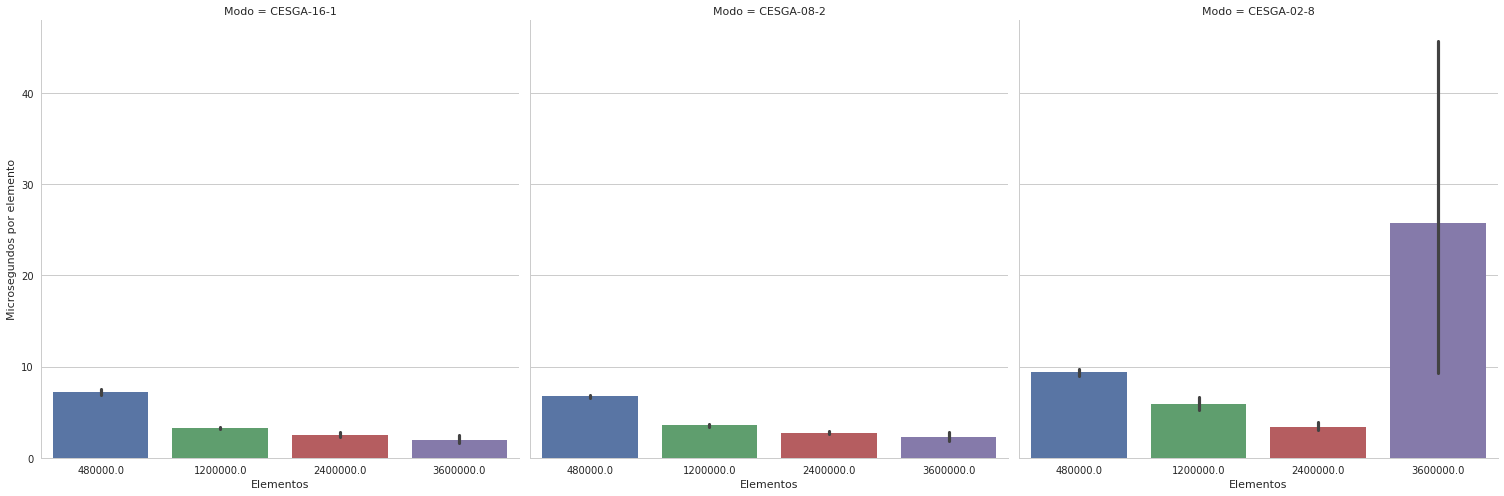

In [5]:
elems = np.array([])
mode = np.array([])
micros = np.array([])
for elements in [480000, 1200000, 2400000, 3600000]:

    df = pd.read_csv("cesga/results-"+str(elements)+"-1-1-"+str(elements/30)+"-16-1.csv")
    length = df["TOTAL_PROCESSING"].size
    elems = np.append(elems, np.repeat(elements, length))
    mode = np.append(mode, np.repeat("CESGA-16-1", length))
    micros = np.append(micros, (df["TOTAL_PROCESSING"]*1000/elements).as_matrix())
    
    df = pd.read_csv("cesga/results-"+str(elements)+"-1-1-"+str(elements/30)+"-8-2.csv")
    length = df["TOTAL_PROCESSING"].size
    elems = np.append(elems, np.repeat(elements, length))
    mode = np.append(mode, np.repeat("CESGA-08-2", length))
    micros = np.append(micros, (df["TOTAL_PROCESSING"]*1000/elements).as_matrix())
    
    df = pd.read_csv("cesga/results-"+str(elements)+"-1-1-"+str(elements/30)+"-2-8.csv")
    length = df["TOTAL_PROCESSING"].size
    elems = np.append(elems, np.repeat(elements, length))
    mode = np.append(mode, np.repeat("CESGA-02-8", length))
    micros = np.append(micros, (df["TOTAL_PROCESSING"]*1000/elements).as_matrix())

results = pd.DataFrame({"Elementos":elems, "Modo": mode, "Microsegundos por elemento": micros})
sns.factorplot(x="Elementos", y="Microsegundos por elemento", col="Modo", col_wrap=3, data=results, kind="bar", size=7)